In [1]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras import optimizers

import time 

### Data Processing

In [3]:
df = pd.read_csv('../data/num_data.csv')

In [4]:
dataset = df

In [5]:
dataset.shape

(420768, 16)

In [6]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse

In [7]:
data_size = dataset.shape[0]
train_size=int(data_size * 0.6)
test_size = 100
valid_size = data_size - train_size - test_size

test_next_day = [12, 24, 48]

In [8]:
training_set = dataset[:train_size].iloc[:,4:16].values
valid_set = dataset[train_size:train_size+valid_size].iloc[:,4:16].values
test_set = dataset[data_size-test_size:].iloc[:,4:16].values

In [9]:
y = dataset.iloc[:,4].values
y = y.reshape(-1,1)
n_feature = training_set.shape[1]
y.shape

(420768, 1)

In [11]:
# Scaling the dataset
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
valid_set_scaled = sc.fit_transform(valid_set)
test_set_scaled = sc.fit_transform(test_set)

sc_y = MinMaxScaler(feature_range=(0,1))
y_scaled = sc_y.fit_transform(y)

In [12]:
# split a multivariate sequence into samples
position_of_target = 4
def split_sequences(sequences, n_steps_in, n_steps_out):
    X_, y_ = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1:out_end_ix, position_of_target]
        X_.append(seq_x)
        y_.append(seq_y)
    return np.array(X_), np.array(y_)

In [13]:
n_steps_in = 24
n_steps_out = 24
X_train, y_train = split_sequences(training_set_scaled, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequences(valid_set_scaled, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test_set_scaled, n_steps_in, n_steps_out)

In [15]:
GRU_LSTM_reg = Sequential()
GRU_LSTM_reg.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
GRU_LSTM_reg.add(LSTM(units=50, activation='tanh'))
GRU_LSTM_reg.add(Dense(units=n_steps_out))

DFS_2LSTM = Sequential()
DFS_2LSTM.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],n_feature)))
DFS_2LSTM.add(MaxPooling1D(pool_size=4))
DFS_2LSTM.add(Dropout(0.2))  
DFS_2LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],n_feature), activation='tanh'))
DFS_2LSTM.add(LSTM(units=50,  activation='tanh'))
DFS_2LSTM.add(Dropout(0.190 + 0.0025 * n_steps_in))
DFS_2LSTM.add(Dense(units=n_steps_out))

# Compiling the RNNs
adam = optimizers.Adam(lr=0.01)
GRU_LSTM_reg.compile(optimizer=adam,loss='mean_squared_error')
DFS_2LSTM.compile(optimizer=adam,loss='mean_squared_error')


INFO:plaidml:Opening device "llvm_cpu.0"


In [16]:
RnnModelDict = {'GRU_LSTM': GRU_LSTM_reg}
RnnModelDict = {'DFS_2LSTM': DFS_2LSTM}


X_test_24 = X_test[:24]
y_test_24 = y_test[:24]
rmse_df = pd.DataFrame(columns=['Model', 'train_rmse', 'valid_rmse', 'train_time'])

# RnnModelDict = {'LSTM_GRU': LSTM_GRU_reg}

In [17]:
for model in RnnModelDict:
    regressor = RnnModelDict[model]
    
    print('training start for', model)    
    start = time.process_time()
    regressor.fit(X_train,y_train,epochs=50,batch_size=1024)
    train_time = round(time.process_time() - start, 2)
    
    print('results for training set')
    y_train_pred = regressor.predict(X_train)
#     plot_predictions(y_train,y_train_pred)
    train_rmse = return_rmse(y_train,y_train_pred)
    
    print('results for valid set')
    y_valid_pred = regressor.predict(X_valid)
#     plot_predictions(y_valid,y_valid_pred)
    valid_rmse = return_rmse(y_valid,y_valid_pred)
    
    
#     print('results for test set - 24 hours')
#     y_test_pred24 = regressor.predict(X_test_24)
#     plot_predictions(y_test_24,y_test_pred24)
#     test24_rmse = return_rmse(y_test_24,y_test_pred24)
    
    
    one_df = pd.DataFrame([[model, train_rmse, valid_rmse, train_time]], 
                          columns=['Model', 'train_rmse', 'valid_rmse', 'train_time'])
    rmse_df = pd.concat([rmse_df, one_df])

# save the rmse results 
# rmse_df.to_csv('../rmse_24h_plus_time.csv')


training start for DFS_2LSTM
Epoch 1/50
252414/252414 [==============================] - 97s 383us/step - loss: 0.0048
Epoch 2/50
252414/252414 [==============================] - 77s 305us/step - loss: 0.0041
Epoch 3/50
252414/252414 [==============================] - 79s 314us/step - loss: 0.0039
Epoch 4/50
252414/252414 [==============================] - 79s 311us/step - loss: 0.0037
Epoch 5/50
252414/252414 [==============================] - 81s 322us/step - loss: 0.0034
Epoch 6/50
252414/252414 [==============================] - 87s 343us/step - loss: 0.0032
Epoch 7/50
252414/252414 [==============================] - 85s 337us/step - loss: 0.0030
Epoch 8/50
252414/252414 [==============================] - 84s 333us/step - loss: 0.0028
Epoch 9/50
252414/252414 [==============================] - 82s 326us/step - loss: 0.0026
Epoch 10/50
252414/252414 [==============================] - 80s 316us/step - loss: 0.0025
Epoch 11/50
252414/252414 [==============================] - 80s 317us

In [19]:
history = regressor.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_valid, y_valid),
                        verbose=2, shuffle=False)
# plot history

plt.figure(figsize=(30, 15))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Transform back and plot
y_train_origin = y[:train_size-46]
y_valid_origin = y[train_size:train_size+valid_size]

y_train_pred = regressor.predict(X_train)
y_train_pred_origin = sc_y.inverse_transform(y_train_pred)

y_valid_pred = regressor.predict(X_valid)
y_valid_pred_origin = sc_y.inverse_transform(y_valid_pred)

_y_train_pred_origin = y_train_pred_origin[:, 0:1]
_y_valid_pred_origin = y_valid_pred_origin[:, 0:1]



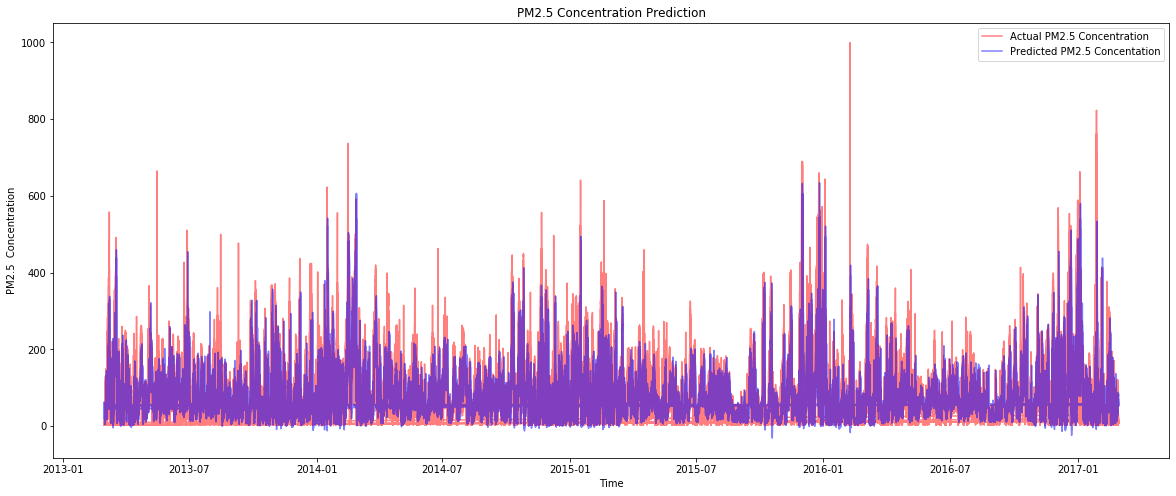

In [151]:
plt.figure(figsize=(20, 8));
plt.plot(pd.to_datetime(valid_original.index), valid_original, 
         alpha=0.5, color='red', label='Actual PM2.5 Concentration',)
plt.plot(pd.to_datetime(valid_original.index), y_valid_pred_origin[:,0:1], 
         alpha=0.5, color='blue', label='Predicted PM2.5 Concentation')
plt.title('PM2.5 Concentration Prediction')
plt.xlabel('Time')
plt.ylabel('PM2.5  Concentration')
plt.legend()
plt.show()


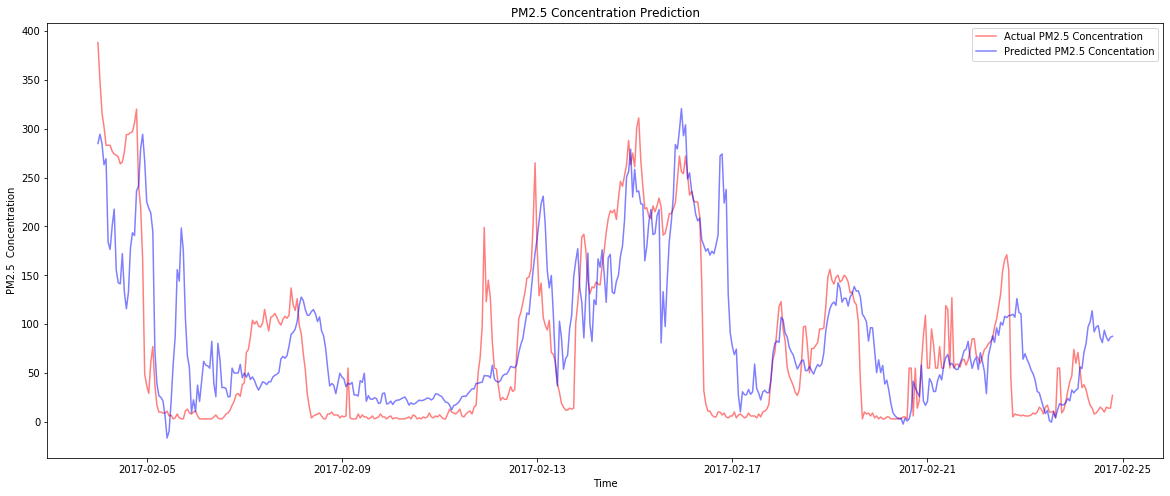

In [145]:
sample = 500
plt.figure(figsize=(20, 8));
plt.plot(pd.to_datetime(valid_original.index[-500:]), valid_original[-500:], 
         alpha=0.5, color='red', label='Actual PM2.5 Concentration',)
plt.plot(pd.to_datetime(valid_original.index[-500:]), y_valid_pred_origin[:,23:24][-500:], 
         alpha=0.5, color='blue', label='Predicted PM2.5 Concentation')
plt.title('PM2.5 Concentration Prediction')
plt.xlabel('Time')
plt.ylabel('PM2.5  Concentration')
plt.legend()
plt.show()

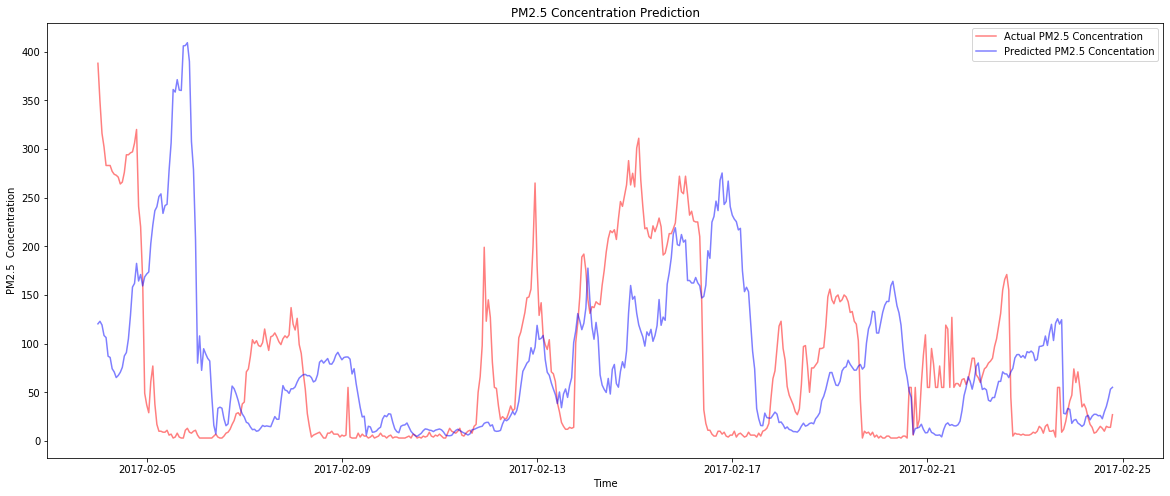